# FRAUD - 4 : GAN Generation of Synthetic Data
Team Members :
* Sanskriti Agarwal - CS24MTECH14002
* Kocherla Sai Kiran - AI24MTECH02003
* Kota Dhana Lakshmi - AI22BTECH11012

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [ ]:
# ==== Load Data ====
df = pd.read_excel("data.xlsx")
print("Original DataFrame shape:", df.shape)

Original DataFrame shape: (1199, 10)


#  WGAN-GP for High-Fidelity Synthetic Tabular Data Generation

We implement a **Wasserstein GAN with Gradient Penalty (WGAN-GP)** to generate realistic synthetic tabular data. The model is enhanced with:

- **Feature Matching Loss**: Aligns intermediate critic activations between real and fake samples.
- **Correlation Matching Loss**: Preserves inter-feature dependencies by minimizing differences in Pearson correlation matrices.

###  Key Steps:
- **Outlier Removal**: Uses z-score filtering on selected columns (`sal_pur_rat`, `lib_igst_itc_rat`).
- **Normalization**: Applies `StandardScaler` to standardize features.
- **GAN Training**: Trains a generator and critic with Wasserstein loss + gradient penalty for stability.
- **Enhanced Generator Objective**: Combines adversarial, feature matching, and correlation matching losses.
- **Evaluation**: Synthetic vs. real data compared using KDE plots and correlation heatmaps.
- **Output**: Saves inverse-transformed synthetic samples to CSV (`synthetic_wgan_gp.csv`).

>  Training is performed for 1500 epochs with 15 critic updates per generator step.

In [ ]:
# ==== Outlier Removal ====
def remove_outliers_zscore(df, col, threshold=3):
    """
    Remove rows from DataFrame `df` where the absolute z-score for column `col`
    exceeds the given threshold.
    """
    # Compute z-scores for the column (ignore NaN values)
    z_scores = zscore(df[col].dropna())
    # Create a boolean mask for values within the threshold
    mask = np.abs(z_scores) < threshold
    # Use the mask to filter the rows using the index of non-NaN values
    return df.loc[df[col].dropna().index[mask]]

# Remove outliers from 'sal_pur_rat' with threshold of 3
if 'sal_pur_rat' in df.columns:
    df = remove_outliers_zscore(df, 'sal_pur_rat', threshold=3)
    print("After removing outliers from 'sal_pur_rat':", df.shape)
else:
    print("Column 'sal_pur_rat' not found, skipping outlier removal for it.")

# Remove outliers from 'lib_igst_itc_rat' with threshold of 0.1
if 'lib_igst_itc_rat' in df.columns:
    df = remove_outliers_zscore(df, 'lib_igst_itc_rat', threshold=0.1)
    print("After removing outliers from 'lib_igst_itc_rat':", df.shape)
else:
    print("Column 'lib_igst_itc_rat' not found, skipping outlier removal for it.")

# ==== Load and Normalize Data ====
scaler = StandardScaler()
data = scaler.fit_transform(df.values.astype(np.float32))
data_tensor = torch.tensor(data, dtype=torch.float32)
dataloader = DataLoader(TensorDataset(data_tensor), batch_size=64, shuffle=True)

# ==== Generator and Critic with Feature Matching ====
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, output_dim)
        )

    def forward(self, z):
        return self.net(z)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.act1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.act2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x, return_features=False):
        x = self.act1(self.fc1(x))
        features = self.act2(self.fc2(x))
        score = self.fc3(features)
        if return_features:
            return score, features
        return score

# ==== Gradient Penalty Function ====
def gradient_penalty(critic, real_data, fake_data):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1).to(real_data.device)
    alpha = alpha.expand_as(real_data)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates.requires_grad_(True)
    d_interpolates = critic(interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True
    )[0]
    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp

# ==== Function to Compute Batch Correlation Matrix ====
def compute_corr(x):
    """
    Compute the Pearson correlation matrix for a tensor x of shape [batch_size, features].
    """
    # Center the data
    x_centered = x - x.mean(dim=0, keepdim=True)
    # Compute covariance matrix (unbiased estimator)
    cov = (x_centered.t() @ x_centered) / (x.shape[0] - 1 + 1e-8)
    # Standard deviations from the covariance diagonal
    std = torch.sqrt(torch.diag(cov) + 1e-8)
    std_matrix = std.unsqueeze(1) * std.unsqueeze(0) + 1e-8
    corr = cov / std_matrix
    return corr

# ==== Training Loop Setup ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 32
lr = 1e-4
lambda_gp = 10
lambda_fm = 10.0    # Weight for feature matching loss
lambda_corr = 5.0   # Weight for correlation matching loss

gen = Generator(latent_dim, data.shape[1]).to(device)
critic = Critic(data.shape[1]).to(device)

opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.5, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.5, 0.9))

n_epochs = 1500  # Training for 1500 epochs
n_critic = 15   # Number of critic updates per generator update

# ==== Logging for Analysis ====
d_losses = []
g_losses = []

for epoch in range(n_epochs):
    for real_batch, in dataloader:
        real_batch = real_batch.to(device)
        batch_size = real_batch.size(0)

        # === Critic Training ===
        for _ in range(n_critic):
            noise = torch.randn(batch_size, latent_dim).to(device)
            fake_batch = gen(noise).detach()

            d_real = critic(real_batch).mean()
            d_fake = critic(fake_batch).mean()
            gp = gradient_penalty(critic, real_batch, fake_batch)
            d_loss = -(d_real - d_fake) + lambda_gp * gp

            opt_critic.zero_grad()
            d_loss.backward()
            opt_critic.step()

        # === Generator Training with Feature Matching & Correlation Matching ===
        noise = torch.randn(batch_size, latent_dim).to(device)
        fake_batch = gen(noise)
        # Obtain critic scores and features for fake data
        d_fake_score, fake_features = critic(fake_batch, return_features=True)
        # Obtain features for the real batch using the same critic
        _, real_features = critic(real_batch, return_features=True)

        # Standard adversarial loss
        g_adv_loss = -d_fake_score.mean()
        # Feature matching loss: match the mean of intermediate features
        fm_loss = F.mse_loss(fake_features.mean(dim=0), real_features.mean(dim=0))
        # Correlation matching loss: compare Pearson correlation matrices
        corr_fake = compute_corr(fake_batch)
        corr_real = compute_corr(real_batch)
        corr_loss = F.mse_loss(corr_fake, corr_real)

        # Total generator loss includes all components
        g_loss = g_adv_loss + lambda_fm * fm_loss + lambda_corr * corr_loss

        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, D Loss: {d_loss.item():.4f}, "
              f"D Real: {d_real.item():.4f}, D Fake: {d_fake.item():.4f}, "
              f"GP: {gp.item():.4f}, G Loss: {g_loss.item():.4f}")

After removing outliers from 'sal_pur_rat': (1197, 10)
After removing outliers from 'lib_igst_itc_rat': (1170, 10)


c:\Users\sai_kiran_kocherla\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/1500, D Loss: -0.8571, D Real: 1.8577, D Fake: 0.9566, GP: 0.0044, G Loss: 0.0462
Epoch 50/1500, D Loss: -0.5114, D Real: 1.7240, D Fake: 1.0469, GP: 0.0166, G Loss: -0.4213
Epoch 100/1500, D Loss: -0.8213, D Real: 2.1335, D Fake: 1.1080, GP: 0.0204, G Loss: -0.6341
Epoch 150/1500, D Loss: -0.8116, D Real: 2.2257, D Fake: 1.2393, GP: 0.0175, G Loss: -0.7147
Epoch 200/1500, D Loss: -0.5830, D Real: 1.9682, D Fake: 1.2332, GP: 0.0152, G Loss: -0.6570
Epoch 250/1500, D Loss: -0.5059, D Real: 2.2017, D Fake: 1.5872, GP: 0.0109, G Loss: -1.2426
Epoch 300/1500, D Loss: -0.4827, D Real: 2.1900, D Fake: 1.6191, GP: 0.0088, G Loss: -0.8632
Epoch 350/1500, D Loss: -0.2796, D Real: 2.3653, D Fake: 2.0229, GP: 0.0063, G Loss: -1.4963
Epoch 400/1500, D Loss: -0.4833, D Real: 3.2261, D Fake: 2.6591, GP: 0.0084, G Loss: -2.2933
Epoch 450/1500, D Loss: -0.4577, D Real: 4.3064, D Fake: 3.7533, GP: 0.0096, G Loss: -3.1811
Epoch 500/1500, D Loss: -0.5070, D Real: 4.7231, D Fake: 4.0675, GP: 0.014

#  Post-Training Analysis & Synthetic Data Evaluation

After training, we analyze the training dynamics and evaluate the quality of the generated synthetic data.

###  Training Dynamics:
- Compute the **mean and standard deviation of loss changes** across epochs for both generator and critic.
- Plot **loss curves** to visualize training behavior over time.

###  Statistical Comparison:
- Generate 1000 synthetic samples using the trained generator.
- Compare **mean and standard deviation** across all features between real and synthetic data.
- Output:
  - `Mean diff`: Average absolute difference in feature-wise means
  - `Std diff`: Average absolute difference in feature-wise standard deviations

###  Synthetic Data Export:
- Generate 500 new synthetic samples.
- Apply inverse transform to bring features back to the original scale.
- Save the final synthetic dataset to **`synthetic_wgan_gp.csv`** for downstream tasks.



--- Post Training Analysis ---
Mean D Loss Change: 0.000040
Std D Loss Change: 0.357030
Mean G Loss Change: -0.006215
Std G Loss Change: 0.900337


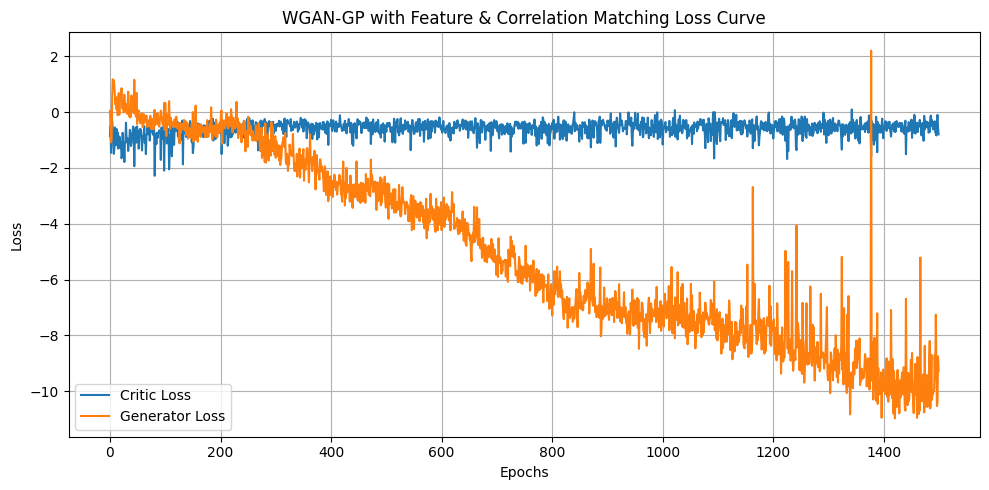

Mean diff: 0.005226762
Std diff: 0.026803572
Synthetic data saved to 'synthetic_wgan_gp.csv'


In [ ]:
# ==== Post-Training Analysis ====
d_diffs = np.diff(d_losses)
g_diffs = np.diff(g_losses)

print("\n--- Post Training Analysis ---")
print(f"Mean D Loss Change: {np.mean(d_diffs):.6f}")
print(f"Std D Loss Change: {np.std(d_diffs):.6f}")
print(f"Mean G Loss Change: {np.mean(g_diffs):.6f}")
print(f"Std G Loss Change: {np.std(g_diffs):.6f}")

# ==== Plot Loss Curves ====
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Critic Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP with Feature & Correlation Matching Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== Evaluate Synthetic Data Statistics ====
with torch.no_grad():
    noise = torch.randn(1000, latent_dim).to(device)
    fake_data = gen(noise).cpu().numpy()

real_stats = (np.mean(data, axis=0), np.std(data, axis=0))
fake_stats = (np.mean(fake_data, axis=0), np.std(fake_data, axis=0))

print("Mean diff:", np.abs(real_stats[0] - fake_stats[0]).mean())
print("Std diff:", np.abs(real_stats[1] - fake_stats[1]).mean())

# ==== Generate and Save Synthetic Data ====
with torch.no_grad():
    z = torch.randn(500, latent_dim).to(device)
    fake_data = gen(z).cpu().numpy()
    # Inverse transform back to the original scale
    fake_data = scaler.inverse_transform(fake_data)
    synthetic_df = pd.DataFrame(fake_data, columns=df.columns)
    synthetic_df.to_csv("synthetic_wgan_gp.csv", index=False)
    print("Synthetic data saved to 'synthetic_wgan_gp.csv'")

#  Synthetic vs. Real Data: Statistical Visualization

This section evaluates the similarity between real and generated data using both **feature-wise distributions** and **inter-feature correlations**.

###  Feature Distribution Comparison:
- For each feature:
  - We Plot **Kernel Density Estimates (KDEs)** of real vs. synthetic data.
  - Visually assess how well the generator has captured the marginal distribution (shape, skewness, modality).

###  Pearson Correlation Heatmaps:
- Compute **Pearson correlation matrices** for both real and synthetic datasets.
- Plot side-by-side heatmaps using `seaborn` to:
  - Identify how well the inter-feature relationships are preserved.
  - Ensure that the synthetic data mimics not just individual features but also the multivariate structure.

> These visualizations are essential for qualitative validation of synthetic data fidelity.


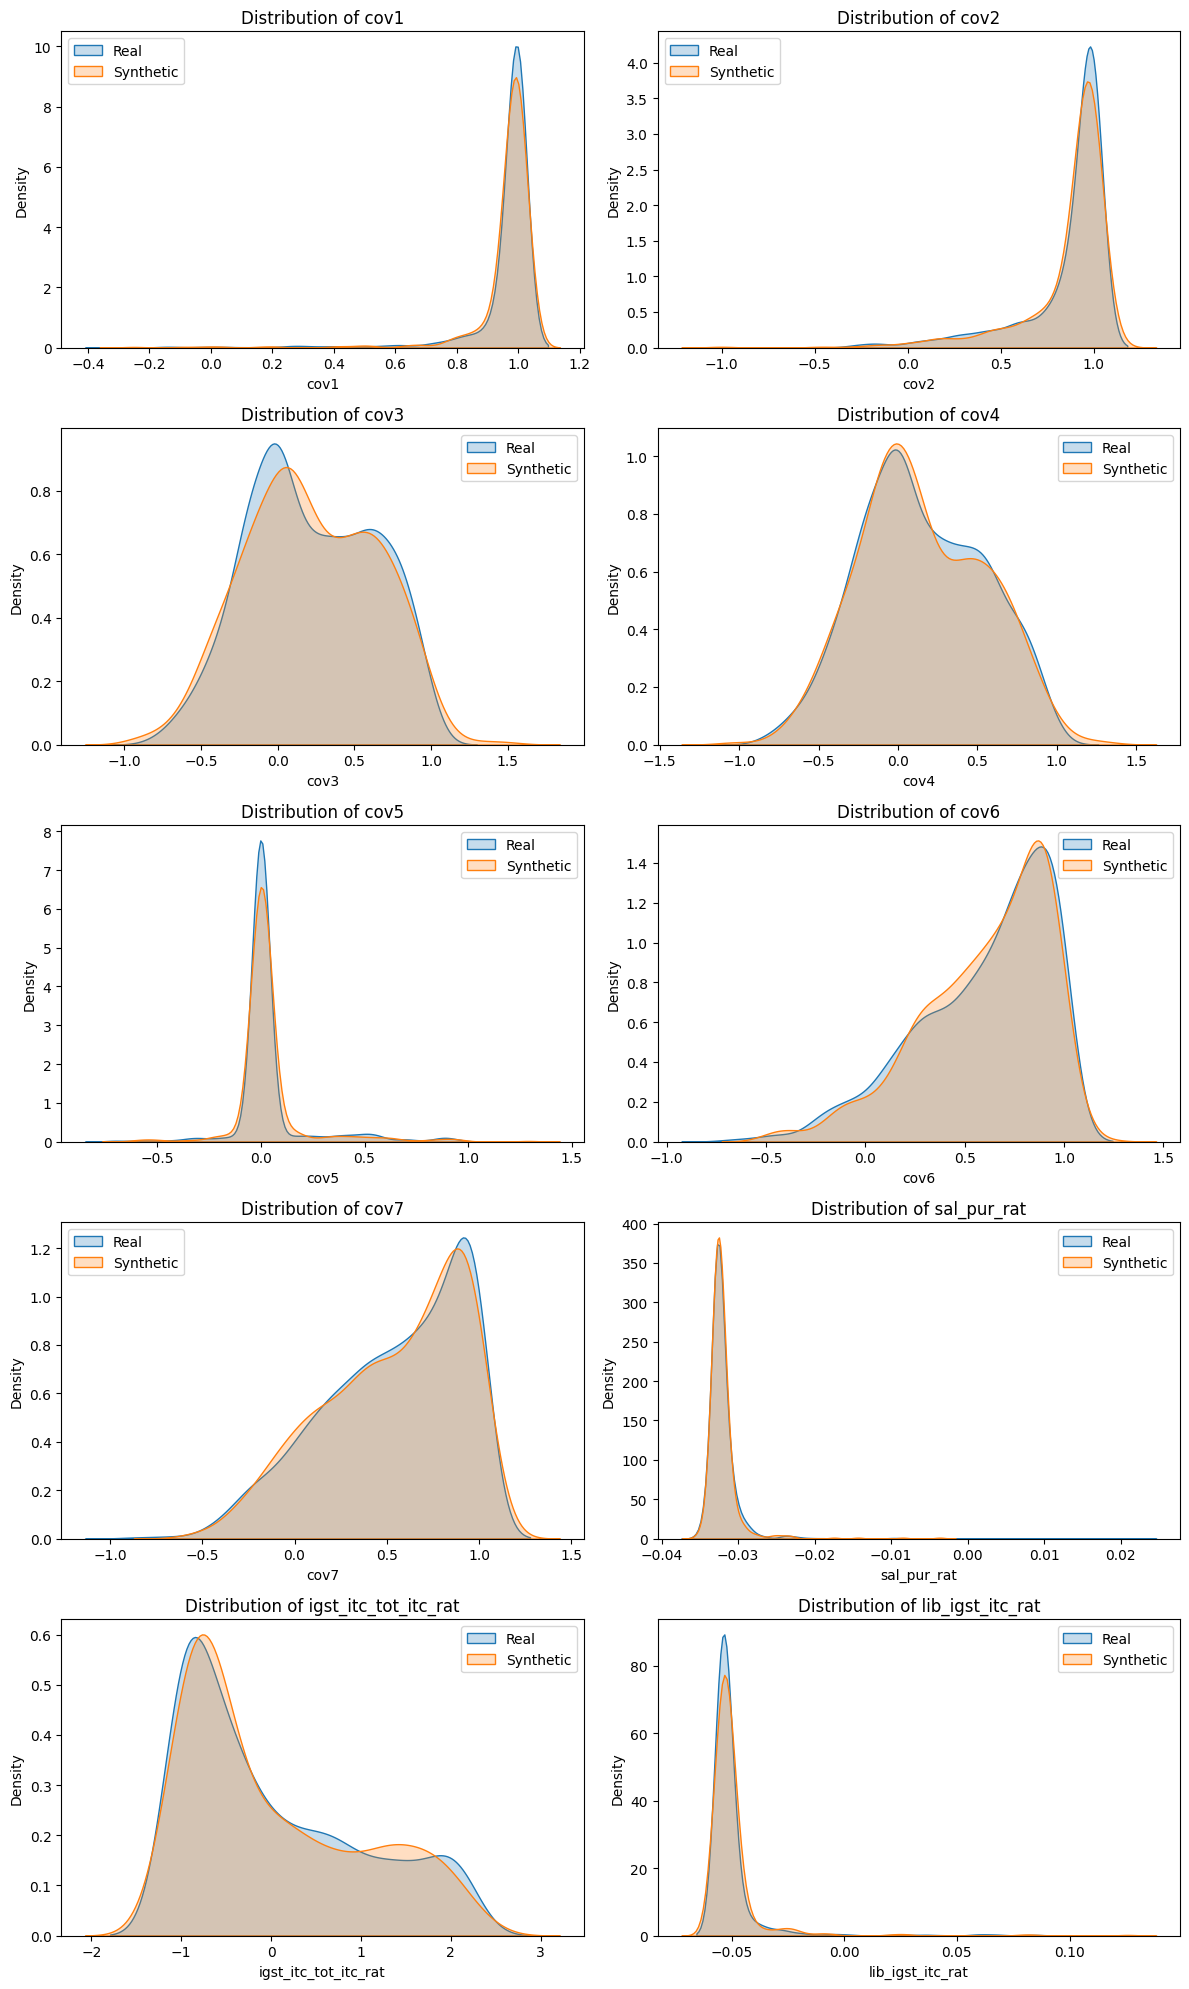

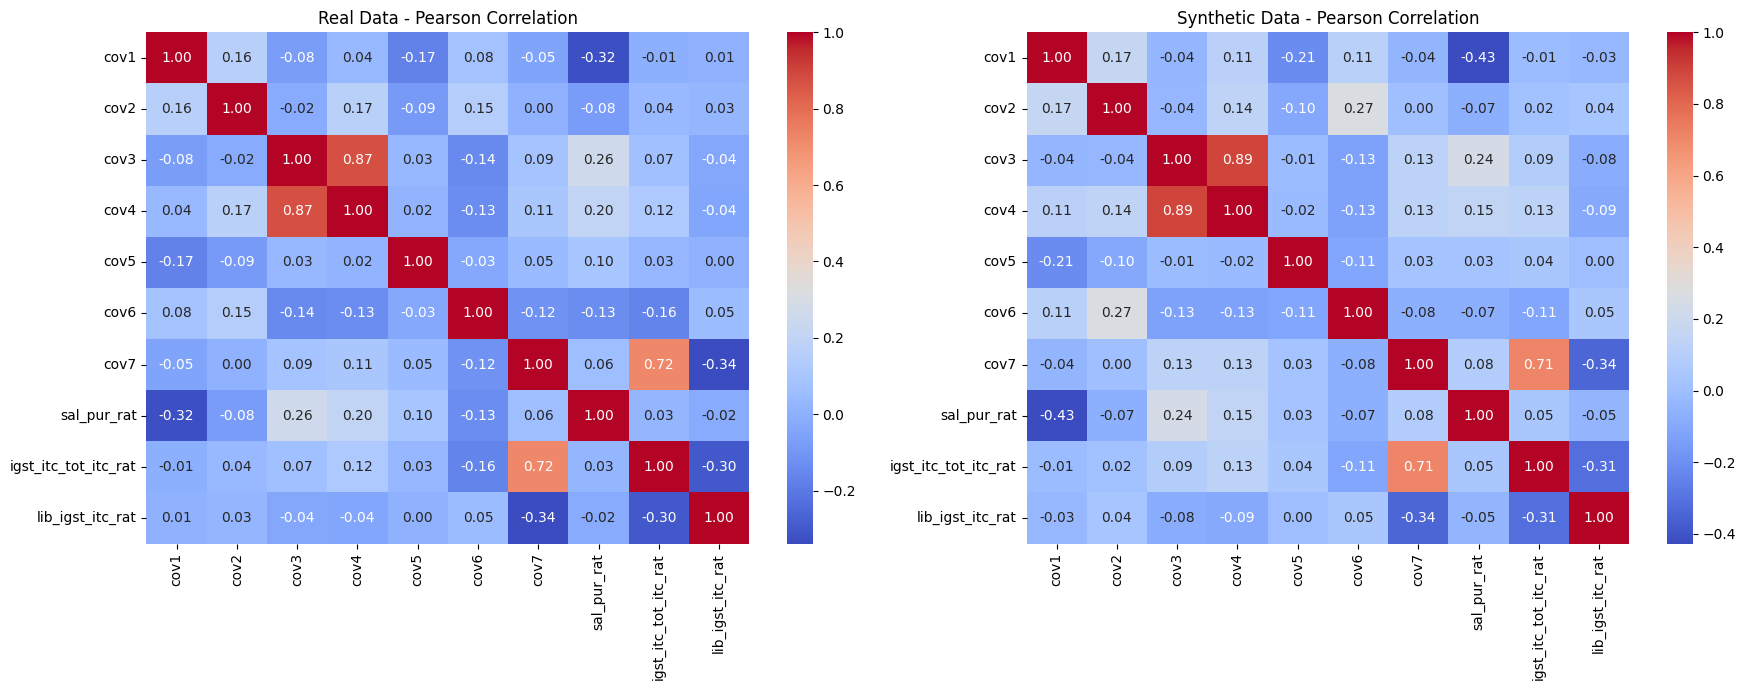

In [ ]:
# ==== Visualize Distributions for Each Feature ====
original_data = df.copy()
num_features = len(original_data.columns)
cols = 2
rows = (num_features + 1) // cols

plt.figure(figsize=(12, 4 * rows))
for i, col in enumerate(original_data.columns):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(original_data[col], label='Real', fill=True)
    sns.kdeplot(synthetic_df[col], label='Synthetic', fill=True)
    plt.title(f'Distribution of {col}')
    plt.legend()

plt.tight_layout()
plt.savefig("feature_distributions.png")
plt.show()

# ==== Compute and Plot Pearson Correlation Heatmaps ====
corr_real = original_data.corr(method='pearson')
corr_synth = synthetic_df.corr(method='pearson')

fig, axs = plt.subplots(1, 2, figsize=(18, 7))
sns.heatmap(corr_real, annot=True, fmt=".2f", cmap="coolwarm", ax=axs[0])
axs[0].set_title("Real Data - Pearson Correlation")

sns.heatmap(corr_synth, annot=True, fmt=".2f", cmap="coolwarm", ax=axs[1])
axs[1].set_title("Synthetic Data - Pearson Correlation")

plt.tight_layout()
plt.savefig("correlation_heatmaps.png")
plt.show()

In [ ]:
import numpy as np

# real & synthetic correlation matrices
corr_r = original_data.corr().values
corr_s = synthetic_df.corr().values

# 1) Mean absolute correlation difference
mae_corr = np.mean(np.abs(corr_r - corr_s))

# 2) Pearson correlation between the two flattened lower‑triangles
mask = np.tril(np.ones_like(corr_r), k=-1).astype(bool)
real_vals  = corr_r[mask]
synth_vals = corr_s[mask]
corr_between = np.corrcoef(real_vals, synth_vals)[0,1]

print(f"Mean‑abs(corr diff): {mae_corr:.4f}")
print(f"Corr‑matrix similarity: {corr_between:.4f}")


Mean‑abs(corr diff): 0.0295
Corr‑matrix similarity: 0.9809
